# Playground:  Lipid droplets

This notebook contains the workflows for lipid droplets, and serves as a starting point for developing a classic segmentation workflow for your lipid droplet data. 

----------------------------------------

Based on: 

* [Connexin-43](https://www.allencell.org/cell-observations/category/connexin43)

----------------------------------------
I think that the best match to the lipid droplets is Connexin-43. 

Key steps of the workflows:

* AC: Auto-Contrast
* G2: 2D Gaussian Smoothing
* S3: 3D Spot Filter
*  S: Size Filter

In [1]:
import numpy as np

# package for 3d visualization
from itkwidgets import view                              
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [24, 12]

# package for io 
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter

# function for core algorithm
from aicssegmentation.core.seg_dot import dot_3d_wrapper
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_slice_by_slice
from skimage.morphology import remove_small_objects

## Loading the data

In [2]:
FILE_NAME = '/Users/asakalish/Projects/LD_test/Input/field_0_30.tif'
reader = AICSImage(FILE_NAME) 
IMG = reader.data.astype(np.float32)

print(IMG.shape)
IMG = np.squeeze(IMG,axis=1)

print((np.squeeze(IMG,axis=1)).shape)

(1, 1, 1, 31, 256, 256)
(1, 31, 256, 256)


## Preview of the image

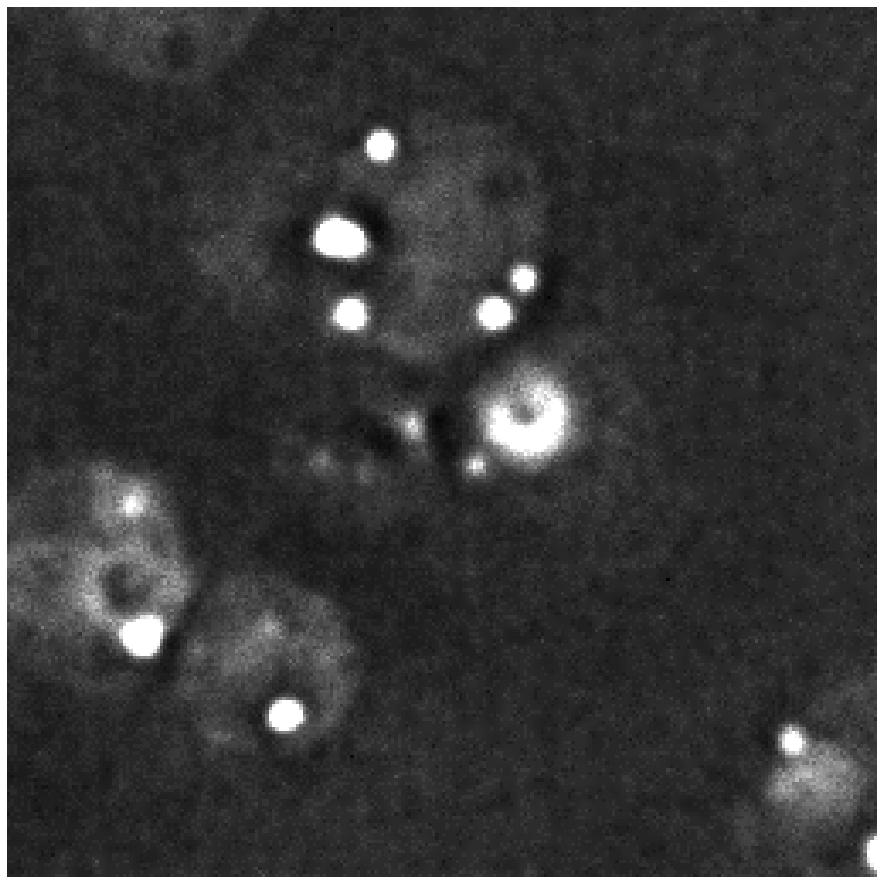

In [3]:
N_CHANNELS = IMG.shape[1]
MID_SLICE = np.int(0.5*IMG.shape[2])

fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
if N_CHANNELS>1:
    for channel in range(N_CHANNELS):
        ax[channel].axis('off')
        ax[channel].imshow(IMG[0,channel,MID_SLICE,:,:], cmap=plt.cm.gray)
else:
    ax.axis('off')
    ax.imshow(IMG[0,0,MID_SLICE,:,:], cmap=plt.cm.gray)

In [4]:
#####################
structure_channel = 0
#####################

struct_img0 = IMG[0,structure_channel,:,:,:].copy()
view(single_fluorescent_view(struct_img0))

Viewer(rendered_image=<itk.itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7fa881…

## Image segmentation

### Step 1: Pre-Processing

About selected algorithms and tuned parameters

* **Intensity normalization**: Parameter `intensity_scaling_param` has two options: two values, say `[A, B]`, or single value, say `[K]`. For the first case, `A` and `B` are non-negative values indicating that the full intensity range of the stack will first be cut-off into **[mean - A * std, mean + B * std]** and then rescaled to **[0, 1]**. The smaller the values of `A` and `B` are, the higher the contrast will be. For the second case, `K`>0 indicates min-max Normalization with an absolute intensity upper bound `K` (i.e., anything above `K` will be chopped off and reset as the minimum intensity of the stack) and `K`=0 means min-max Normalization without any intensity bound.

    * Parameter:  `intensity_scaling_param = [1, 40]`


* **Smoothing**: 2D gaussian smoothing slice by slice with `gaussian_smoothing_sigma = 1`.  The large the value is, the more the image will be smoothed. 

In [5]:
################################
## PARAMETERS for this step ##
intensity_scaling_param = [3, 6.5]
gaussian_smoothing_sigma = 1.5
################################

# intensity normalization
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)

# smoothing with 2d gaussian filter slice by slice 
structure_img_smooth = image_smoothing_gaussian_slice_by_slice(struct_img, sigma=gaussian_smoothing_sigma)

In [6]:
view(single_fluorescent_view(structure_img_smooth))

Viewer(rendered_image=<itk.itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7fa868…

#### If the contrast looks too off, you can tune the normalization parameters.

We have a function to give you some suggestions. If you have certain preference, you can adjust the values based on the suggestion.

***After you decide the parameters, you have to re-run the code above with the new parameter*** `intensity_scaling_param = ` 

In [7]:
from aicssegmentation.core.pre_processing_utils import suggest_normalization_param
suggest_normalization_param(struct_img0)

mean intensity of the stack: 67.20497131347656
the standard deviation of intensity of the stack: 20.846858978271484
0.9999 percentile of the stack intensity is: 213.9572296142578
minimum intensity of the stack: 1.0
maximum intensity of the stack: 213.9572296142578
suggested upper range is 7.0, which is 213.13298416137695
suggested lower range is 3.0, which is 4.664394378662109
So, suggested parameter for normalization is [3.0, 7.0]
To further enhance the contrast: You may increase the first value (may loss some dim parts), or decrease the second value(may loss some texture in super bright regions)
To slightly reduce the contrast: You may decrease the first value, or increase the second value


### Step 2: Core Algorithm

#### Apply 3D Spot filter (S3)

Parameter syntax: `[[scale_1, cutoff_1], [scale_2, cutoff_2], ....]` 
* `scale_x` is set based on the estimated radius of your target dots. For example, if visually the diameter of the dots is usually 3~4 pixels, then you may want to set `scale_x` as `1` or something near `1` (like `1.25`). Multiple scales can be used, if you have dots of very different sizes.  
* `cutoff_x` is a threshold applied on the actual filter reponse to get the binary result. Smaller `cutoff_x` may yielf more dots and fatter segmentation, while larger `cutoff_x` could be less permisive and yield less dots and slimmer segmentation. 

Parameter:  `s3_param = [[1, 0.031]]`


In [15]:
################################
## PARAMETERS for this step ##
dot_size = 3.5
thresh = 0.32
s3_param = [[dot_size, thresh]]
################################

bw = dot_3d_wrapper(structure_img_smooth, s3_param)

In [9]:
viewer_bw = view(segmentation_quick_view(bw))
viewer_bw

Viewer(rendered_image=<itk.itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x7fa8…

##### After quickly visualizing the segmentation results, you can also visualize the segmentation and original image side by side
##### You may select an ROI to inspect the details

* Option 1: Easy ROI selection, but NOT recommended if you are using a laptop

You can select an ROI in above visualization ('viewer_bw'); otherwise, the default ROI is the full image

[See this video for How to select ROI](https://www.youtube.com/watch?v=ZO8ey6-tF_0&index=3&list=PL2lHcsoU0YJsh6f8j2vbhg2eEpUnKEWcl)

* Option 2: Manually type in ROI coordinates

Type in the coordinates of upper left corner and lower right corner of the ROI in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y]. 

In [21]:
# Option 1:
view(seg_fluo_side_by_side(struct_img,bw,roi=['ROI',viewer_bw.roi_slice()]))

# Option 2: 
#view(seg_fluo_side_by_side(struct_img,bw,roi=['M',[570,370,730,440]]))

Viewer(rendered_image=<itk.itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7fa87d…

##### Is the segmentation satisfactory? Here are some possible criteria:

--------------------------
* Is there any object should be detected but not? Try to reduce `cutoff_x`
* Is there any object should not be detected but actually appear in the result? Try to increase `cutoff_x` or try a larger `scale_x`
* Is the segmented width of the objects is fatter than it should be? Try to increase `cutoff_x` or try a smaller `scale_x`
* Is there any object that should be solid but segmented as fragmented pieces? Try to increase `scale_x`
* Are you observing objects with very different width? Try multiple sets of `scale_x` and `cutoff_x` 
--------------------------

#### Step 3: Post-Processing 

In [11]:
################################
## PARAMETERS for this step ##
minArea = 10
################################

seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

## Result inspection

In [12]:
viewer_final = view(segmentation_quick_view(seg))
viewer_final

Viewer(rendered_image=<itk.itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x7fa8…

### You can also focus your inspection on a small ROI

* Option 1: Easy ROI selection, but NOT recommended if you are using a laptop

You can select an ROI in above visualization ('viewer_final'); otherwise, the default ROI is the full image

[See this video for How to select ROI](https://www.youtube.com/watch?v=ZO8ey6-tF_0&index=3&list=PL2lHcsoU0YJsh6f8j2vbhg2eEpUnKEWcl)

* Option 2: Manually type in ROI coordinates

Type in the coordinates of upper left corner and lower right corner of the ROI in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y].

In [13]:
# Option 1: 
view(seg_fluo_side_by_side(struct_img, seg, roi=['ROI',viewer_final.roi_slice()]))

# Option 2: 
#view(seg_fluo_side_by_side(struct_img, seg, roi=['M',[267,474, 468, 605]]))

Viewer(rendered_image=<itk.itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7fa868…

### You may also physically save the segmentation results into a ome.tif file

In [19]:
seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
writer = OmeTiffWriter('/Users/asakalish/Projects/test30_thresh' + str(thresh) + '_dotsize' 
                       + str(dot_size) + '_intscale' + str(intensity_scaling_param) + '.tiff')
writer.save(out)

In [20]:
str(intensity_scaling_param)

'[3, 6.5]'